In [32]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

In [ ]:
with open('normalized_openmath_eval_20260118_123416.json.json', 'r') as f:
    data = json.load(f)

models = sorted(set(d['model'] for d in data))
sources = sorted(set(d['problem_source'] for d in data))

print(f"Models: {models}")
print(f"Problem sources: {sources}")

Models: ['flash', 'flash-think', 'grok', 'llama', 'opus', 'pro-think']
Problem sources: ['augmented_gsm8k', 'augmented_math', 'gsm8k', 'math']


In [36]:
by_idx = defaultdict(lambda: {'expected': None, 'problem_source': None, 'responses': {}})

for entry in data:
    idx = entry['idx']
    model = entry['model']
    by_idx[idx]['expected'] = entry['expected']
    by_idx[idx]['problem_source'] = entry['problem_source']
    by_idx[idx]['responses'][model] = entry['normalized_response']

print(f"Total problems: {len(by_idx)}")

Total problems: 100


In [37]:
model_order = ['llama', 'grok', 'flash', 'flash-think', 'pro-think', 'opus']

def is_null(response):
    return response is None or response == "None"

null_counts = {model: 0 for model in models}
for idx, info in by_idx.items():
    for model in models:
        response = info['responses'].get(model)
        if is_null(response):
            null_counts[model] += 1

print("Null counts per model:")
for model in model_order:
    if model in null_counts:
        print(f"  {model:15s}: {null_counts[model]}/{len(by_idx)}")

Null counts per model:
  llama          : 8/100
  grok           : 1/100
  flash          : 0/100
  flash-think    : 5/100
  pro-think      : 4/100
  opus           : 7/100


In [38]:
def is_null(response):
    return response is None or response == "None"

print(f"\nTotal problems: {len(by_idx)}")
print(f"Problems where all models have responses: {sum(1 for info in by_idx.values() if all(not is_null(info['responses'].get(m)) for m in models))}")


Total problems: 100
Problems where all models have responses: 85


In [39]:
def is_null(response):
    return response is None or response == "None"

def calculate_accuracy(data_dict, gt_field='expected', filter_nulls=True):
    if gt_field == 'frontier':
        models_to_compare = [m for m in models if m not in ['opus', 'pro-think']]
    elif gt_field == 'opus':
        models_to_compare = [m for m in models if m != 'opus']
    else:
        models_to_compare = models
    
    results = {model: {'correct': 0, 'total': 0} for model in models_to_compare}
    results_by_source = {source: {model: {'correct': 0, 'total': 0} for model in models_to_compare} for source in sources}
    
    for idx, info in data_dict.items():
        if filter_nulls:
            if not all(not is_null(info['responses'].get(m)) for m in models):
                continue
        
        if gt_field == 'frontier':
            opus_response = info['responses'].get('opus')
            prothink_response = info['responses'].get('pro-think')
            if is_null(opus_response) or is_null(prothink_response):
                continue
            if opus_response != prothink_response:
                continue
            gt = opus_response
        elif gt_field == 'opus':
            gt = info['responses']['opus']
        else:
            gt = info[gt_field]
        
        if is_null(gt):
            continue
        
        source = info['problem_source']
        
        for model in models_to_compare:
            response = info['responses'].get(model)
            
            if filter_nulls and is_null(response):
                continue
            
            results[model]['total'] += 1
            results_by_source[source][model]['total'] += 1
            
            if not is_null(response) and response == gt:
                results[model]['correct'] += 1
                results_by_source[source][model]['correct'] += 1
    
    accuracies = {model: results[model]['correct'] / results[model]['total'] if results[model]['total'] > 0 else 0.0 for model in models_to_compare}
    accuracies_by_source = {}
    for source in sources:
        accuracies_by_source[source] = {
            model: results_by_source[source][model]['correct'] / results_by_source[source][model]['total'] if results_by_source[source][model]['total'] > 0 else 0.0
            for model in models_to_compare
        }
    
    return accuracies, accuracies_by_source, results, results_by_source

## Accuracy vs Expected (Dataset GT) - Not Filtered (nulls counted as incorrect)

In [40]:
acc_expected_unfiltered, acc_by_source_expected_unfiltered, results_expected_unfiltered, results_by_source_expected_unfiltered = calculate_accuracy(by_idx, 'expected', filter_nulls=False)

print("\nOverall Accuracy (vs Expected) - Nulls counted as incorrect:")
for model in model_order:
    if model in acc_expected_unfiltered:
        acc = acc_expected_unfiltered[model]
        correct = results_expected_unfiltered[model]['correct']
        total = results_expected_unfiltered[model]['total']
        print(f"  {model:15s}: {acc:.2f} ({correct}/{total})")

print("\nAccuracy by Problem Source (vs Expected) - Nulls counted as incorrect:")
for source in sources:
    print(f"\n  {source}:")
    for model in model_order:
        if model in acc_by_source_expected_unfiltered[source]:
            acc = acc_by_source_expected_unfiltered[source][model]
            correct = results_by_source_expected_unfiltered[source][model]['correct']
            total = results_by_source_expected_unfiltered[source][model]['total']
            print(f"    {model:15s}: {acc:.2f} ({correct}/{total})")


Overall Accuracy (vs Expected) - Nulls counted as incorrect:
  llama          : 0.68 (68/100)
  grok           : 0.86 (86/100)
  flash          : 0.89 (89/100)
  flash-think    : 0.84 (84/100)
  pro-think      : 0.85 (85/100)
  opus           : 0.84 (84/100)

Accuracy by Problem Source (vs Expected) - Nulls counted as incorrect:

  augmented_gsm8k:
    llama          : 0.68 (17/25)
    grok           : 0.80 (20/25)
    flash          : 0.76 (19/25)
    flash-think    : 0.80 (20/25)
    pro-think      : 0.76 (19/25)
    opus           : 0.76 (19/25)

  augmented_math:
    llama          : 0.40 (10/25)
    grok           : 0.68 (17/25)
    flash          : 0.80 (20/25)
    flash-think    : 0.68 (17/25)
    pro-think      : 0.68 (17/25)
    opus           : 0.68 (17/25)

  gsm8k:
    llama          : 0.96 (24/25)
    grok           : 1.00 (25/25)
    flash          : 1.00 (25/25)
    flash-think    : 1.00 (25/25)
    pro-think      : 1.00 (25/25)
    opus           : 1.00 (25/25)

  math

## Accuracy vs Expected (Dataset GT) - Per-Model Denominator (nulls excluded from each model's calculation)

In [65]:
def calculate_accuracy_per_model_denom(data_dict, gt_field='expected'):
    models_to_compare = models
    results = {model: {'correct': 0, 'total': 0} for model in models_to_compare}
    results_by_source = {source: {model: {'correct': 0, 'total': 0} for model in models_to_compare} for source in sources}
    
    for idx, info in data_dict.items():
        gt = info[gt_field] if gt_field == 'expected' else info['responses']['opus']
        if is_null(gt):
            continue
        
        source = info['problem_source']
        
        for model in models_to_compare:
            response = info['responses'].get(model)
            
            if is_null(response):
                continue
            
            results[model]['total'] += 1
            results_by_source[source][model]['total'] += 1
            
            if response == gt:
                results[model]['correct'] += 1
                results_by_source[source][model]['correct'] += 1
    
    accuracies = {model: results[model]['correct'] / results[model]['total'] if results[model]['total'] > 0 else 0.0 for model in models_to_compare}
    accuracies_by_source = {}
    for source in sources:
        accuracies_by_source[source] = {
            model: results_by_source[source][model]['correct'] / results_by_source[source][model]['total'] if results_by_source[source][model]['total'] > 0 else 0.0
            for model in models_to_compare
        }
    
    return accuracies, accuracies_by_source, results, results_by_source

acc_expected_per_denom, acc_by_source_expected_per_denom, results_expected_per_denom, results_by_source_expected_per_denom = calculate_accuracy_per_model_denom(by_idx, 'expected')

print("\nOverall Accuracy (vs Expected) - Per-model denominator (nulls excluded):")
for model in model_order:
    if model in acc_expected_per_denom:
        acc = acc_expected_per_denom[model]
        correct = results_expected_per_denom[model]['correct']
        total = results_expected_per_denom[model]['total']
        print(f"  {model:15s}: {acc:.2f} ({correct}/{total})")

print("\nAccuracy by Problem Source (vs Expected) - Per-model denominator (nulls excluded):")
for source in sources:
    print(f"\n  {source}:")
    for model in model_order:
        if model in acc_by_source_expected_per_denom[source]:
            acc = acc_by_source_expected_per_denom[source][model]
            correct = results_by_source_expected_per_denom[source][model]['correct']
            total = results_by_source_expected_per_denom[source][model]['total']
            print(f"    {model:15s}: {acc:.2f} ({correct}/{total})")

print("\n\nAccuracy Table:")
model_name_map = {
    'llama': 'llama 3.1 8B',
    'grok': 'grok-4-fast',
    'flash': 'gemini 3 flash (no thinking)',
    'flash-think': 'gemini 3 flash (thinking)',
    'pro-think': 'Gemini Pro Think',
    'opus': 'Claude Opus'
}

models_in_results = [m for m in model_order if m in acc_expected_per_denom]
model_names = [model_name_map.get(m, m) for m in models_in_results]
column_order = ['Overall', 'gsm8k', 'augmented_gsm8k', 'math', 'augmented_math']

table_data = {}
for col in column_order:
    if col == 'Overall':
        table_data[col] = []
    elif col in sources:
        table_data[col] = []
    else:
        continue

for model in models_in_results:
    table_data['Overall'].append(acc_expected_per_denom[model])
    for col in column_order[1:]:
        if col in sources and model in acc_by_source_expected_per_denom[col]:
            table_data[col].append(acc_by_source_expected_per_denom[col][model])
        elif col in sources:
            table_data[col].append(np.nan)

df = pd.DataFrame(table_data, index=model_names)
df.columns = ['Overall', 'gsm8k', 'augmented_gsm8k', 'math', 'augmented_math']

print("\n" + "=" * 80)
print("Accuracy vs Expected GT (Per-Model Denominator)")
print("=" * 80)
styled_df = df.style.format('{:.2f}', na_rep='-').set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
display(styled_df)
print("=" * 80)


Overall Accuracy (vs Expected) - Per-model denominator (nulls excluded):
  llama          : 0.74 (68/92)
  grok           : 0.87 (86/99)
  flash          : 0.89 (89/100)
  flash-think    : 0.88 (84/95)
  pro-think      : 0.89 (85/96)
  opus           : 0.90 (84/93)

Accuracy by Problem Source (vs Expected) - Per-model denominator (nulls excluded):

  augmented_gsm8k:
    llama          : 0.71 (17/24)
    grok           : 0.80 (20/25)
    flash          : 0.76 (19/25)
    flash-think    : 0.80 (20/25)
    pro-think      : 0.76 (19/25)
    opus           : 0.76 (19/25)

  augmented_math:
    llama          : 0.48 (10/21)
    grok           : 0.71 (17/24)
    flash          : 0.80 (20/25)
    flash-think    : 0.74 (17/23)
    pro-think      : 0.77 (17/22)
    opus           : 0.85 (17/20)

  gsm8k:
    llama          : 0.96 (24/25)
    grok           : 1.00 (25/25)
    flash          : 1.00 (25/25)
    flash-think    : 1.00 (25/25)
    pro-think      : 1.00 (25/25)
    opus           : 1

,Overall,gsm8k,augmented_gsm8k,math,augmented_math
llama,0.74,0.96,0.71,0.77,0.48
grok,0.87,1.00,0.80,0.96,0.71
flash,0.89,1.00,0.76,1.00,0.80
flash-think,0.88,1.00,0.80,1.00,0.74
pro-think,0.89,1.00,0.76,1.00,0.77
opus,0.90,1.00,0.76,1.00,0.85


## Accuracy vs Expected (Dataset GT) - Filtered (exclude problems where ANY model has null)

In [ ]:
acc_expected, acc_by_source_expected, results_expected, results_by_source_expected = calculate_accuracy(by_idx, 'expected', filter_nulls=True)

print("\nOverall Accuracy (vs Expected):")
for model in model_order:
    if model in acc_expected:
        acc = acc_expected[model]
        correct = results_expected[model]['correct']
        total = results_expected[model]['total']
        print(f"  {model:15s}: {acc:.2f} ({correct}/{total})")

print("\nAccuracy by Problem Source (vs Expected):")
for source in sources:
    print(f"\n  {source}:")
    for model in model_order:
        if model in acc_by_source_expected[source]:
            acc = acc_by_source_expected[source][model]
            correct = results_by_source_expected[source][model]['correct']
            total = results_by_source_expected[source][model]['total']
            print(f"    {model:15s}: {acc:.2f} ({correct}/{total})")


Overall Accuracy (vs Expected):
  llama          : 0.78 (66/85)
  grok           : 0.92 (78/85)
  flash          : 0.92 (78/85)
  flash-think    : 0.92 (78/85)
  pro-think      : 0.91 (77/85)
  opus           : 0.91 (77/85)

Accuracy by Problem Source (vs Expected):

  augmented_gsm8k:
    llama          : 0.71 (17/24)
    grok           : 0.83 (20/24)
    flash          : 0.79 (19/24)
    flash-think    : 0.83 (20/24)
    pro-think      : 0.79 (19/24)
    opus           : 0.79 (19/24)

  augmented_math:
    llama          : 0.59 (10/17)
    grok           : 0.82 (14/17)
    flash          : 0.88 (15/17)
    flash-think    : 0.82 (14/17)
    pro-think      : 0.82 (14/17)
    opus           : 0.82 (14/17)

  gsm8k:
    llama          : 0.96 (24/25)
    grok           : 1.00 (25/25)
    flash          : 1.00 (25/25)
    flash-think    : 1.00 (25/25)
    pro-think      : 1.00 (25/25)
    opus           : 1.00 (25/25)

  math:
    llama          : 0.79 (15/19)
    grok           : 1.00 (1

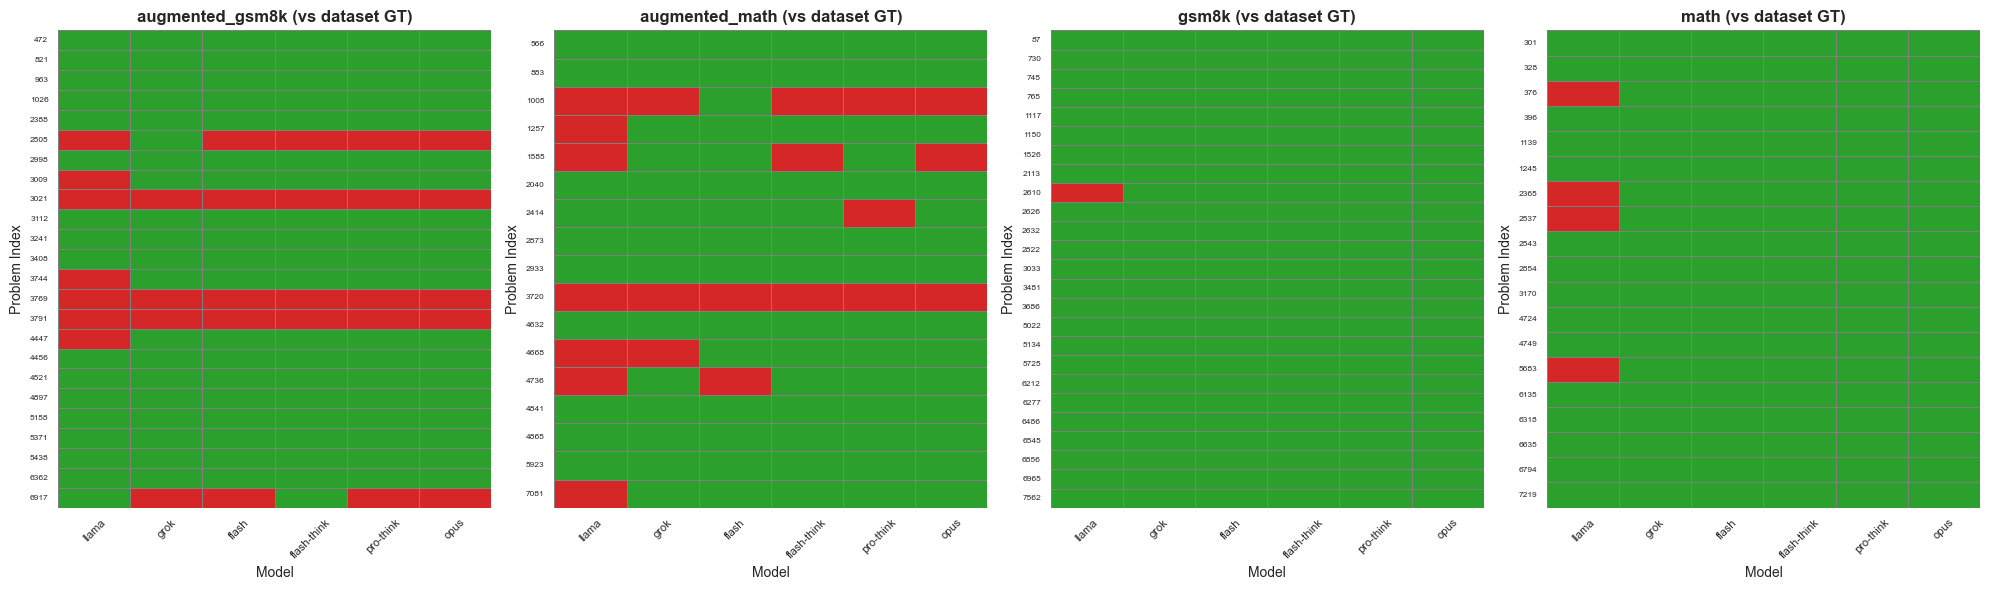

In [ ]:
def create_accuracy_grid(data_dict, gt_field='expected', title_suffix=''):
    models_to_compare = [m for m in model_order if (gt_field != 'opus' or m != 'opus') and m in models]
    grids = {source: [] for source in sources}
    idxs_by_source = {source: [] for source in sources}
    
    for idx, info in sorted(data_dict.items()):
        source = info['problem_source']
        gt = info[gt_field] if gt_field == 'expected' else info['responses']['opus']
        
        if is_null(gt):
            continue
        
        row = []
        for model in models_to_compare:
            response = info['responses'][model]
            is_correct = (not is_null(response) and response == gt)
            row.append(1 if is_correct else 0)
        
        grids[source].append(row)
        idxs_by_source[source].append(idx)
    
    fig, axes = plt.subplots(1, len(sources), figsize=(20, max(6, len(max(grids.values(), key=len)) * 0.15)))
    if len(sources) == 1:
        axes = [axes]
    
    for i, source in enumerate(sources):
        if len(grids[source]) == 0:
            continue
        
        grid = np.array(grids[source])
        ax = axes[i]
        
        cmap = sns.color_palette(["#d62728", "#2ca02c"], as_cmap=True)
        sns.heatmap(grid, cmap=cmap, cbar=False, ax=ax, 
                   xticklabels=models_to_compare, yticklabels=idxs_by_source[source],
                   linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
        
        ax.set_title(f"{source}{title_suffix}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Model', fontsize=10)
        ax.set_ylabel('Problem Index', fontsize=10)
        ax.tick_params(axis='y', labelsize=6)
        ax.tick_params(axis='x', labelsize=8, rotation=45)
    
    plt.tight_layout()
    plt.show()

filtered_data = {idx: info for idx, info in by_idx.items() if all(not is_null(info['responses'].get(m)) for m in models)}
create_accuracy_grid(filtered_data, 'expected', ' (vs dataset GT)')

## Opus & Pro-Think Agreement

## Null Counts Per Model (on Frontier Dataset - where opus & pro-think agree)

In [60]:
opus_prothink_agreement = {'total': 0, 'agree': 0, 'disagree': 0, 'both_null': 0, 'one_null': 0}
agreement_by_source = {source: {'total': 0, 'agree': 0, 'disagree': 0, 'both_null': 0, 'one_null': 0} for source in sources}

for idx, info in by_idx.items():
    opus_response = info['responses'].get('opus')
    prothink_response = info['responses'].get('pro-think')
    source = info['problem_source']
    
    opus_null = is_null(opus_response)
    prothink_null = is_null(prothink_response)
    
    opus_prothink_agreement['total'] += 1
    agreement_by_source[source]['total'] += 1
    
    if opus_null and prothink_null:
        opus_prothink_agreement['both_null'] += 1
        agreement_by_source[source]['both_null'] += 1
    elif opus_null or prothink_null:
        opus_prothink_agreement['one_null'] += 1
        agreement_by_source[source]['one_null'] += 1
    elif opus_response == prothink_response:
        opus_prothink_agreement['agree'] += 1
        agreement_by_source[source]['agree'] += 1
    else:
        opus_prothink_agreement['disagree'] += 1
        agreement_by_source[source]['disagree'] += 1

print("Opus & Pro-Think Agreement:")
print(f"  Total problems: {opus_prothink_agreement['total']}")
print(f"  Agree (both non-null and equal): {opus_prothink_agreement['agree']} ({opus_prothink_agreement['agree']/opus_prothink_agreement['total']*100:.1f}%)")
print(f"  Disagree (both non-null but different): {opus_prothink_agreement['disagree']} ({opus_prothink_agreement['disagree']/opus_prothink_agreement['total']*100:.1f}%)")
print(f"  Both null: {opus_prothink_agreement['both_null']} ({opus_prothink_agreement['both_null']/opus_prothink_agreement['total']*100:.1f}%)")
print(f"  One null: {opus_prothink_agreement['one_null']} ({opus_prothink_agreement['one_null']/opus_prothink_agreement['total']*100:.1f}%)")

non_null_total = opus_prothink_agreement['agree'] + opus_prothink_agreement['disagree']
if non_null_total > 0:
    print(f"\n  Agreement rate (excluding nulls): {opus_prothink_agreement['agree']}/{non_null_total} ({opus_prothink_agreement['agree']/non_null_total*100:.1f}%)")

print("\nAgreement by Problem Source:")
for source in sources:
    src_stats = agreement_by_source[source]
    print(f"\n  {source}:")
    print(f"    Total: {src_stats['total']}")
    print(f"    Agree: {src_stats['agree']} ({src_stats['agree']/src_stats['total']*100:.1f}%)")
    print(f"    Disagree: {src_stats['disagree']} ({src_stats['disagree']/src_stats['total']*100:.1f}%)")
    print(f"    Both null: {src_stats['both_null']} ({src_stats['both_null']/src_stats['total']*100:.1f}%)")
    print(f"    One null: {src_stats['one_null']} ({src_stats['one_null']/src_stats['total']*100:.1f}%)")
    src_non_null = src_stats['agree'] + src_stats['disagree']
    if src_non_null > 0:
        print(f"    Agreement rate (excluding nulls): {src_stats['agree']}/{src_non_null} ({src_stats['agree']/src_non_null*100:.1f}%)")

Opus & Pro-Think Agreement:
  Total problems: 100
  Agree (both non-null and equal): 89 (89.0%)
  Disagree (both non-null but different): 3 (3.0%)
  Both null: 3 (3.0%)
  One null: 5 (5.0%)

  Agreement rate (excluding nulls): 89/92 (96.7%)

Agreement by Problem Source:

  augmented_gsm8k:
    Total: 25
    Agree: 24 (96.0%)
    Disagree: 1 (4.0%)
    Both null: 0 (0.0%)
    One null: 0 (0.0%)
    Agreement rate (excluding nulls): 24/25 (96.0%)

  augmented_math:
    Total: 25
    Agree: 18 (72.0%)
    Disagree: 2 (8.0%)
    Both null: 3 (12.0%)
    One null: 2 (8.0%)
    Agreement rate (excluding nulls): 18/20 (90.0%)

  gsm8k:
    Total: 25
    Agree: 25 (100.0%)
    Disagree: 0 (0.0%)
    Both null: 0 (0.0%)
    One null: 0 (0.0%)
    Agreement rate (excluding nulls): 25/25 (100.0%)

  math:
    Total: 25
    Agree: 22 (88.0%)
    Disagree: 0 (0.0%)
    Both null: 0 (0.0%)
    One null: 3 (12.0%)
    Agreement rate (excluding nulls): 22/22 (100.0%)


In [56]:
frontier_data = {idx: info for idx, info in by_idx.items() 
                 if not is_null(info['responses'].get('opus')) 
                 and not is_null(info['responses'].get('pro-think'))
                 and info['responses'].get('opus') == info['responses'].get('pro-think')}

frontier_null_counts = {model: 0 for model in models}
frontier_null_counts_by_source = {source: {model: 0 for model in models} for source in sources}

for idx, info in frontier_data.items():
    source = info['problem_source']
    for model in models:
        response = info['responses'].get(model)
        if is_null(response):
            frontier_null_counts[model] += 1
            frontier_null_counts_by_source[source][model] += 1

print(f"Null counts per model (on frontier dataset - {len(frontier_data)} problems where opus & pro-think agree):")
for model in model_order:
    if model in frontier_null_counts:
        print(f"  {model:15s}: {frontier_null_counts[model]}/{len(frontier_data)}")

print("\nNull counts by Problem Source (on frontier dataset):")
for source in sources:
    source_total = sum(1 for idx, info in frontier_data.items() if info['problem_source'] == source)
    if source_total > 0:
        print(f"\n  {source} ({source_total} problems):")
        for model in model_order:
            if model in frontier_null_counts_by_source[source]:
                null_count = frontier_null_counts_by_source[source][model]
                print(f"    {model:15s}: {null_count}/{source_total}")

Null counts per model (on frontier dataset - 89 problems where opus & pro-think agree):
  llama          : 3/89
  grok           : 0/89
  flash          : 0/89
  flash-think    : 3/89
  pro-think      : 0/89
  opus           : 0/89

Null counts by Problem Source (on frontier dataset):

  augmented_gsm8k (24 problems):
    llama          : 0/24
    grok           : 0/24
    flash          : 0/24
    flash-think    : 0/24
    pro-think      : 0/24
    opus           : 0/24

  augmented_math (18 problems):
    llama          : 2/18
    grok           : 0/18
    flash          : 0/18
    flash-think    : 1/18
    pro-think      : 0/18
    opus           : 0/18

  gsm8k (25 problems):
    llama          : 0/25
    grok           : 0/25
    flash          : 0/25
    flash-think    : 0/25
    pro-think      : 0/25
    opus           : 0/25

  math (22 problems):
    llama          : 1/22
    grok           : 0/22
    flash          : 0/22
    flash-think    : 2/22
    pro-think      : 0/22
  

## Accuracy vs Frontier GT - Per-Model Denominator (nulls excluded from each model's calculation)

In [67]:
def calculate_accuracy_per_model_denom_frontier(data_dict):
    models_to_compare = [m for m in models if m not in ['opus', 'pro-think']]
    results = {model: {'correct': 0, 'total': 0} for model in models_to_compare}
    results_by_source = {source: {model: {'correct': 0, 'total': 0} for model in models_to_compare} for source in sources}
    
    for idx, info in data_dict.items():
        opus_response = info['responses'].get('opus')
        prothink_response = info['responses'].get('pro-think')
        if is_null(opus_response) or is_null(prothink_response):
            continue
        if opus_response != prothink_response:
            continue
        gt = opus_response
        
        source = info['problem_source']
        
        for model in models_to_compare:
            response = info['responses'].get(model)
            
            if is_null(response):
                continue
            
            results[model]['total'] += 1
            results_by_source[source][model]['total'] += 1
            
            if response == gt:
                results[model]['correct'] += 1
                results_by_source[source][model]['correct'] += 1
    
    accuracies = {model: results[model]['correct'] / results[model]['total'] if results[model]['total'] > 0 else 0.0 for model in models_to_compare}
    accuracies_by_source = {}
    for source in sources:
        accuracies_by_source[source] = {
            model: results_by_source[source][model]['correct'] / results_by_source[source][model]['total'] if results_by_source[source][model]['total'] > 0 else 0.0
            for model in models_to_compare
        }
    
    return accuracies, accuracies_by_source, results, results_by_source

acc_frontier_per_denom, acc_by_source_frontier_per_denom, results_frontier_per_denom, results_by_source_frontier_per_denom = calculate_accuracy_per_model_denom_frontier(by_idx)

print(f"\nProblems where opus and pro-think agree: {len(frontier_data)}/{len(by_idx)}")
print("\nOverall Accuracy (vs Frontier GT) - Per-model denominator (nulls excluded):")
for model in model_order:
    if model in acc_frontier_per_denom:
        acc = acc_frontier_per_denom[model]
        correct = results_frontier_per_denom[model]['correct']
        total = results_frontier_per_denom[model]['total']
        print(f"  {model:15s}: {acc:.2f} ({correct}/{total})")

print("\nAccuracy by Problem Source (vs Frontier GT) - Per-model denominator (nulls excluded):")
for source in sources:
    print(f"\n  {source}:")
    for model in model_order:
        if model in acc_by_source_frontier_per_denom[source]:
            acc = acc_by_source_frontier_per_denom[source][model]
            correct = results_by_source_frontier_per_denom[source][model]['correct']
            total = results_by_source_frontier_per_denom[source][model]['total']
            print(f"    {model:15s}: {acc:.2f} ({correct}/{total})")

print("\n\nAccuracy Table:")
model_name_map = {
    'llama': 'llama 3.1 8B',
    'grok': 'grok-4-fast',
    'flash': 'gemini 3 flash (no thinking)',
    'flash-think': 'gemini 3 flash (thinking)',
    'pro-think': 'Gemini Pro Think',
    'opus': 'Claude Opus'
}

models_in_results = [m for m in model_order if m in acc_frontier_per_denom]
model_names = [model_name_map.get(m, m) for m in models_in_results]
column_order = ['Overall', 'gsm8k', 'augmented_gsm8k', 'math', 'augmented_math']

table_data = {}
for col in column_order:
    if col == 'Overall':
        table_data[col] = []
    elif col in sources:
        table_data[col] = []
    else:
        continue

for model in models_in_results:
    table_data['Overall'].append(acc_frontier_per_denom[model])
    for col in column_order[1:]:
        if col in sources and model in acc_by_source_frontier_per_denom[col]:
            table_data[col].append(acc_by_source_frontier_per_denom[col][model])
        elif col in sources:
            table_data[col].append(np.nan)

df = pd.DataFrame(table_data, index=model_names)
df.columns = ['Overall', 'gsm8k', 'augmented_gsm8k', 'math', 'augmented_math']

print("\n" + "=" * 80)
print("Accuracy vs Frontier GT (Per-Model Denominator)")
print("=" * 80)
styled_df = df.style.format('{:.2f}', na_rep='-').set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
display(styled_df)
print("=" * 80)


Problems where opus and pro-think agree: 89/100

Overall Accuracy (vs Frontier GT) - Per-model denominator (nulls excluded):
  llama          : 0.79 (68/86)
  grok           : 0.93 (83/89)
  flash          : 0.97 (86/89)
  flash-think    : 0.98 (84/86)

Accuracy by Problem Source (vs Frontier GT) - Per-model denominator (nulls excluded):

  augmented_gsm8k:
    llama          : 0.75 (18/24)
    grok           : 0.92 (22/24)
    flash          : 0.96 (23/24)
    flash-think    : 0.92 (22/24)

  augmented_math:
    llama          : 0.56 (9/16)
    grok           : 0.83 (15/18)
    flash          : 0.89 (16/18)
    flash-think    : 1.00 (17/17)

  gsm8k:
    llama          : 0.96 (24/25)
    grok           : 1.00 (25/25)
    flash          : 1.00 (25/25)
    flash-think    : 1.00 (25/25)

  math:
    llama          : 0.81 (17/21)
    grok           : 0.95 (21/22)
    flash          : 1.00 (22/22)
    flash-think    : 1.00 (20/20)


Accuracy Table:

Accuracy vs Frontier GT (Per-Model Deno

,Overall,gsm8k,augmented_gsm8k,math,augmented_math
llama 3.1 8B,0.79,0.96,0.75,0.81,0.56
grok-4-fast,0.93,1.00,0.92,0.95,0.83
gemini 3 flash (no thinking),0.97,1.00,0.96,1.00,0.89
gemini 3 flash (thinking),0.98,1.00,0.92,1.00,1.00


## Accuracy vs Frontier GT (Opus & Pro-Think Agreement) - Not Filtered (nulls counted as incorrect)

In [ ]:
frontier_data = {idx: info for idx, info in by_idx.items() 
                 if not is_null(info['responses'].get('opus')) 
                 and not is_null(info['responses'].get('pro-think'))
                 and info['responses'].get('opus') == info['responses'].get('pro-think')}

acc_frontier_unfiltered, acc_by_source_frontier_unfiltered, results_frontier_unfiltered, results_by_source_frontier_unfiltered = calculate_accuracy(frontier_data, 'frontier', filter_nulls=False)

print(f"\nProblems where opus and pro-think agree: {len(frontier_data)}/{len(by_idx)}")
print("\nOverall Accuracy (vs Frontier GT) - Nulls counted as incorrect:")
for model in model_order:
    if model in acc_frontier_unfiltered:
        acc = acc_frontier_unfiltered[model]
        correct = results_frontier_unfiltered[model]['correct']
        total = results_frontier_unfiltered[model]['total']
        print(f"  {model:15s}: {acc:.2f} ({correct}/{total})")

print("\nAccuracy by Problem Source (vs Frontier GT) - Nulls counted as incorrect:")
for source in sources:
    print(f"\n  {source}:")
    for model in model_order:
        if model in acc_by_source_frontier_unfiltered[source]:
            acc = acc_by_source_frontier_unfiltered[source][model]
            correct = results_by_source_frontier_unfiltered[source][model]['correct']
            total = results_by_source_frontier_unfiltered[source][model]['total']
            print(f"    {model:15s}: {acc:.2f} ({correct}/{total})")


Problems where opus and pro-think agree: 89/100

Overall Accuracy (vs Frontier GT) - Nulls counted as incorrect:
  llama          : 0.76 (68/89)
  grok           : 0.93 (83/89)
  flash          : 0.97 (86/89)
  flash-think    : 0.94 (84/89)
  pro-think      : 1.00 (89/89)
  opus           : 1.00 (89/89)

Accuracy by Problem Source (vs Frontier GT) - Nulls counted as incorrect:

  augmented_gsm8k:
    llama          : 0.75 (18/24)
    grok           : 0.92 (22/24)
    flash          : 0.96 (23/24)
    flash-think    : 0.92 (22/24)
    pro-think      : 1.00 (24/24)
    opus           : 1.00 (24/24)

  augmented_math:
    llama          : 0.50 (9/18)
    grok           : 0.83 (15/18)
    flash          : 0.89 (16/18)
    flash-think    : 0.94 (17/18)
    pro-think      : 1.00 (18/18)
    opus           : 1.00 (18/18)

  gsm8k:
    llama          : 0.96 (24/25)
    grok           : 1.00 (25/25)
    flash          : 1.00 (25/25)
    flash-think    : 1.00 (25/25)
    pro-think      : 1.00 (

## Accuracy vs Frontier GT (Opus & Pro-Think Agreement) - Filtered (exclude problems where ANY model has null)

In [ ]:
frontier_filtered_data = {idx: info for idx, info in frontier_data.items() 
                          if all(not is_null(info['responses'].get(m)) for m in models)}

acc_frontier, acc_by_source_frontier, results_frontier, results_by_source_frontier = calculate_accuracy(frontier_filtered_data, 'frontier', filter_nulls=True)

print(f"\nProblems where opus and pro-think agree (and all models have responses): {len(frontier_filtered_data)}/{len(by_idx)}")
print("\nOverall Accuracy (vs Frontier GT):")
for model in model_order:
    if model in acc_frontier:
        acc = acc_frontier[model]
        correct = results_frontier[model]['correct']
        total = results_frontier[model]['total']
        print(f"  {model:15s}: {acc:.2f} ({correct}/{total})")

print("\nAccuracy by Problem Source (vs Frontier GT):")
for source in sources:
    print(f"\n  {source}:")
    for model in model_order:
        if model in acc_by_source_frontier[source]:
            acc = acc_by_source_frontier[source][model]
            correct = results_by_source_frontier[source][model]['correct']
            total = results_by_source_frontier[source][model]['total']
            print(f"    {model:15s}: {acc:.2f} ({correct}/{total})")


Problems where opus and pro-think agree (and all models have responses): 83/100

Overall Accuracy (vs Frontier GT):
  llama          : 0.80 (66/83)
  grok           : 0.94 (78/83)
  flash          : 0.96 (80/83)
  flash-think    : 0.98 (81/83)
  pro-think      : 1.00 (83/83)
  opus           : 1.00 (83/83)

Accuracy by Problem Source (vs Frontier GT):

  augmented_gsm8k:
    llama          : 0.75 (18/24)
    grok           : 0.92 (22/24)
    flash          : 0.96 (23/24)
    flash-think    : 0.92 (22/24)
    pro-think      : 1.00 (24/24)
    opus           : 1.00 (24/24)

  augmented_math:
    llama          : 0.60 (9/15)
    grok           : 0.80 (12/15)
    flash          : 0.87 (13/15)
    flash-think    : 1.00 (15/15)
    pro-think      : 1.00 (15/15)
    opus           : 1.00 (15/15)

  gsm8k:
    llama          : 0.96 (24/25)
    grok           : 1.00 (25/25)
    flash          : 1.00 (25/25)
    flash-think    : 1.00 (25/25)
    pro-think      : 1.00 (25/25)
    opus           

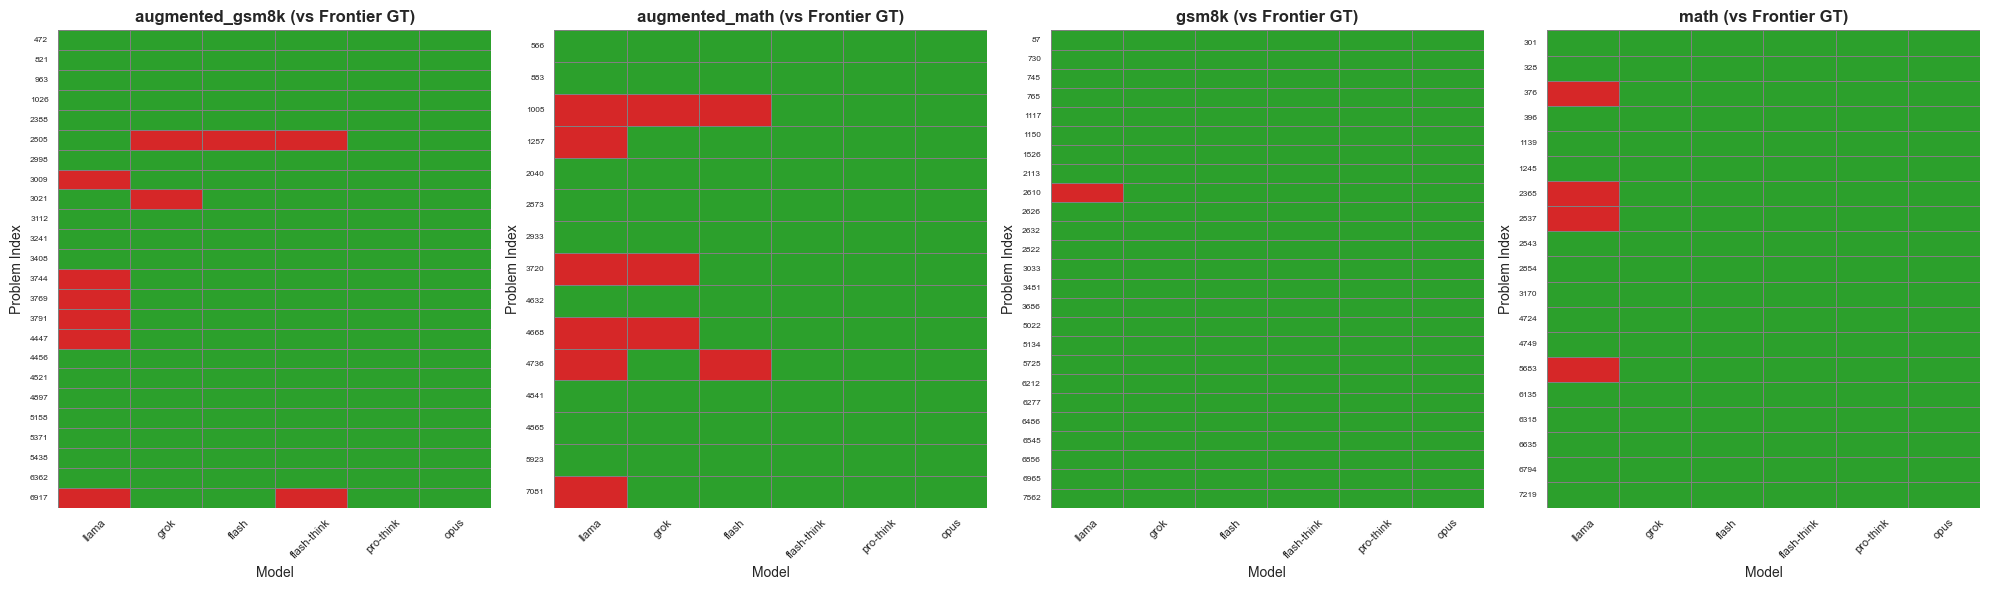

In [51]:
create_accuracy_grid(frontier_filtered_data, 'frontier', ' (vs Frontier GT)')

## Response Times Analysis

In [68]:
with open('results/openmath_eval_20260118_123416.json', 'r') as f:
    timing_data = json.load(f)

times_by_model = {model: [] for model in models}
times_by_model_source = {model: {source: [] for source in sources} for model in models}

for model_name, results_list in timing_data['results'].items():
    for result in results_list:
        elapsed_time = result.get('elapsed_time')
        problem_source = result.get('problem_source')
        if elapsed_time is not None and problem_source in sources:
            times_by_model[model_name].append(elapsed_time)
            times_by_model_source[model_name][problem_source].append(elapsed_time)

mean_times = {model: np.mean(times_by_model[model]) if times_by_model[model] else np.nan 
              for model in models}
mean_times_by_source = {model: {source: np.mean(times_by_model_source[model][source]) 
                                if times_by_model_source[model][source] else np.nan 
                                for source in sources} 
                        for model in models}

print("Mean Response Times by Model:")
for model in model_order:
    if model in mean_times:
        mean_time = mean_times[model]
        count = len(times_by_model[model])
        print(f"  {model:15s}: {mean_time:.2f}s ({count} samples)")

print("\nMean Response Times by Model and Problem Source:")
for source in sources:
    print(f"\n  {source}:")
    for model in model_order:
        if model in mean_times_by_source and source in mean_times_by_source[model]:
            mean_time = mean_times_by_source[model][source]
            count = len(times_by_model_source[model][source])
            if not np.isnan(mean_time):
                print(f"    {model:15s}: {mean_time:.2f}s ({count} samples)")

print("\n\nResponse Times Table:")

model_name_map = {
    'llama': 'llama 3.1 8B',
    'grok': 'grok-4-fast',
    'flash': 'gemini 3 flash (no thinking)',
    'flash-think': 'gemini 3 flash (thinking)',
    'pro-think': 'Gemini Pro Think',
    'opus': 'Claude Opus'
}

models_in_results = [m for m in model_order if m in mean_times]
model_names = [model_name_map.get(m, m) for m in models_in_results]
column_order = ['Overall', 'gsm8k', 'augmented_gsm8k', 'math', 'augmented_math']

table_data = {}
for col in column_order:
    if col == 'Overall':
        table_data[col] = []
    elif col in sources:
        table_data[col] = []
    else:
        continue

for model in models_in_results:
    table_data['Overall'].append(mean_times[model])
    for col in column_order[1:]:
        if col in sources and model in mean_times_by_source and col in mean_times_by_source[model]:
            table_data[col].append(mean_times_by_source[model][col])
        elif col in sources:
            table_data[col].append(np.nan)

df = pd.DataFrame(table_data, index=model_names)
df.columns = ['Overall', 'gsm8k', 'augmented_gsm8k', 'math', 'augmented_math']

print("\n" + "=" * 80)
print("Mean Response Times by Model and Dataset")
print("=" * 80)
styled_df = df.style.format('{:.2f}', na_rep='-').set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
display(styled_df)
print("=" * 80)

Mean Response Times by Model:
  llama          : 7.39s (100 samples)
  grok           : 7.29s (99 samples)
  flash          : 3.06s (100 samples)
  flash-think    : 19.84s (100 samples)
  pro-think      : 33.40s (100 samples)
  opus           : 39.39s (93 samples)

Mean Response Times by Model and Problem Source:

  augmented_gsm8k:
    llama          : 5.20s (25 samples)
    grok           : 5.43s (25 samples)
    flash          : 2.22s (25 samples)
    flash-think    : 24.40s (25 samples)
    pro-think      : 22.03s (25 samples)
    opus           : 24.37s (25 samples)

  augmented_math:
    llama          : 11.76s (25 samples)
    grok           : 15.47s (24 samples)
    flash          : 4.68s (25 samples)
    flash-think    : 30.68s (25 samples)
    pro-think      : 65.81s (25 samples)
    opus           : 66.06s (20 samples)

  gsm8k:
    llama          : 3.83s (25 samples)
    grok           : 2.52s (25 samples)
    flash          : 2.06s (25 samples)
    flash-think    : 8.58s (

,Overall,gsm8k,augmented_gsm8k,math,augmented_math
llama 3.1 8B,7.39,3.83,5.20,8.76,11.76
grok-4-fast,7.29,2.52,5.43,6.05,15.47
gemini 3 flash (no thinking),3.06,2.06,2.22,3.30,4.68
gemini 3 flash (thinking),19.84,8.58,24.40,15.70,30.68
Gemini Pro Think,33.40,11.19,22.03,34.57,65.81
Claude Opus,39.39,18.33,24.37,55.42,66.06
